# Benchmark Evaluation Script

## How to Run 

These are the high level tasks required to replicate the test scenario:
(*paths are considered relative inside the Docker container!*)

1. Start the devcontainer and wait for the container and the workspace to build. 
1. Ensure the `BUILD_BENCHMARK` flag in the `src/soar_ros/CMakeLists.txt` is `ON`; If a change is needed, rebuild the workspace via the build instructions in src/soar_ros/test/benchmark/README.md
1. Create a virtual python environment `python3 -m venv .venv`, activate it (`source .venv/bin/activate`) and install the requirements `pip install -r src/soar_ros/test/benchmark/requirements.txt`
1. Navigate to the `src/soar_ros/test/benchmark/` directory and run the `./benchmark.sh <channels>` script **as instructed below**.
1. Run this Jupyter Notebook to see the results.

## Explanation 

This is the evaluation script for the `soar_ros` benchmark. This benchmark compares three different scenarios:

1. `soar_ros` running without any messaging (no load)
2. `soar_ros` running in single input/ single output (SISO) mode
3. `soar_ros` running in multiple input/ multiple output (MIMO) mode

The _no load_ scenario is intended to capture the performance baseline on the
machine running the benchmark, so relative performance can be measured. 

The general usage of the script is:

```shell
./benchmark.sh <number_of_channels> 
```

**After each frequency, press `CTRL + C` to continue to the next frequency test!** 
Tests will be completed, once you only see the log message `[INFO]
[1766760154.788314964] [system]: Soar decision cycle executed`.

In order to run the tests on your machine, run the following commands on the terminal.

1. No Messaging:

    ```shell
    ./benchmark.sh 0
    ```

    **Special case:** Just stop the benchmark with `CTRL + C` after 5-10
    seconds. There is no need for testing multiple frequencies since the Soar
    kernel is running at maximum speed in any case.

2. SISO

    ```shell
    ./benchmark.sh 1
    ```

3. MIMO

    ```shell
    ./benchmark.sh 2
    ```

The tests save the logs and extracted data via the `parse-logs.py` script into
the `out/<timestamp>/` directory. In order for the following script to analyze
and compare the different test szenarios and results, set up the correct paths
in the next cell **based on your directory names**. The directory names are in
the following schema:

```shell
./out/<ISO8601 timestamp>_CHANNELS_<number_channels>/
```

Only the `<ISO8601 timestamp>_CHANNELS_<number_channels>` part is required for the 
directory names.

In [11]:
# general settings & imports
%matplotlib widget

import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

export_figures = False
plt.rcParams['axes.grid'] = True

In [12]:
# Distribution plot of decision cycle frequencies (No Load) using matplotlib
# Compute histograms and normalize to 100%
def compare_soar_kernel_frequencies(data_frame, scenario: str, legend = True):
    """
    Plot distribution of Soar decision cycle frequencies.
    Creates a single plot with all unique frequencies overlaid.
    
    Parameters:
    -----------
    data_frame : pandas.DataFrame
        Soar decision cycle dataframe with 'frequency' and 'timestamp' columns
    scenario : str
        Scenario name for saving the plot (e.g., "no_load", "siso", "mimo")
    """
    # Get all unique frequencies from the dataframe
    unique_frequencies = sorted(data_frame["frequency"].unique())
    
    plt.figure()
    
    for frequency in unique_frequencies:
        df = data_frame[data_frame["frequency"] == frequency]
        
        if df.empty:
            print(f"Skipping frequency {frequency} Hz - no data available")
            continue
        
        freqs = 1 / df["timestamp"].diff().dropna()
        # Filter out infinite and NaN values
        freqs = freqs[np.isfinite(freqs)]
        
        if len(freqs) == 0:
            print(f"Skipping frequency {frequency} Hz - no valid frequency data")
            continue
        
        hist, bins = np.histogram(freqs, bins=50)
        hist = hist / hist.sum() * 100
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        plt.bar(bin_centers, hist, width=(bins[1]-bins[0]), alpha=0.5, label=f"{frequency} Hz")

        print(f"{scenario} {frequency} Hz: Mean = {freqs.mean():.2f} Hz, SD = {freqs.std():.2f} Hz")

    
    plt.xlabel("Frequency (Hz)")
    plt.xlim(left=0)
    plt.ylabel("Count (%)")
    plt.title(f"Distribution of Soar Decision Cycle Frequencies - {scenario}")
    if legend:
        plt.legend()
    plt.show()
    
    if not os.path.exists("out/images"):
        os.makedirs("out/images")
    plt.title("")
    plt.savefig(f"out/images/kernel_frequency_comparison_{scenario}.pdf", dpi=300)

def analyze_sender_frequency(df,show_plots=False):
    for freq in df["frequency"].unique():
        df_subset = df[(df["frequency"] == freq)]

        for channel in df_subset["channel"].unique():
            df_channel = df_subset[df_subset["channel"] == channel].sort_values("counter")
            # Reset the index so x-axis starts from 0 for each new plot
            mean = (1/df_channel["sender_time"].diff()).mean()
            sd = (1/df_channel["sender_time"].diff()).std()
            print(f"Sender: F {freq} Channel {channel} M: {mean:0.6} Hz, SD: {sd:0.6} Hz")

def plot_dual_axis_comparison(test_data, soar_data, title_prefix="", figsize=(10, 6)):
    """
    Plot test data duration and Soar kernel frequency on aligned dual y-axes.
    Creates a separate plot for each unique frequency in test_data.
    
    Parameters:
    -----------
    test_data : pandas.DataFrame
        Test results dataframe with 'frequency', 'receive_time', and 'duration' columns
    soar_data : pandas.DataFrame
        Soar decision cycle dataframe with 'frequency' and 'timestamp' columns
    title_prefix : str
        Prefix for the plot title (e.g., "SISO", "MIMO")
    figsize : tuple
        Figure size (width, height)
    """
    # Get all unique frequencies from test_data
    unique_frequencies = sorted(test_data["frequency"].unique())
    
    for frequency in unique_frequencies:
        fig, ax1 = plt.subplots(figsize=figsize)
        
        # Data preparation
        df_test = test_data[test_data["frequency"] == frequency]
        df_soar = soar_data[soar_data["frequency"] == frequency]
        
        if df_test.empty or df_soar.empty:
            print(f"Skipping frequency {frequency} Hz - no data available")
            plt.close(fig)
            continue
        
        global_start = min(df_test["receive_time"].min(), df_soar["timestamp"].min())
        
        rel_receive_time = df_test["receive_time"] - global_start
        rel_timestamp = df_soar["timestamp"] - global_start
        freqs = 1 / df_soar["timestamp"].diff().dropna()
        
        min_time = min(rel_receive_time.min(), rel_timestamp.min())
        max_time = max(rel_receive_time.max(), rel_timestamp.max())
        
        # Left y-axis: Duration
        # color1 = 'tab:blue'
        ax1.set_xlabel("Relative Time (s)")
        ax1.set_ylabel("Duration (s)")

        for channel in df_test["channel"].unique():
            df_channel = df_test[df_test["channel"] == channel]
            ax1.plot(rel_receive_time[df_channel.index], df_channel["duration"], marker='o', linestyle='', markersize=2, label=f"Duration Channel {channel}", zorder=2)

        ax1.tick_params(axis='y')
        ax1.set_xlim(min_time, max_time)
        ax1.set_zorder(2)
        ax1.patch.set_visible(False)

        ax2 = ax1.twinx()
        ax2.set_zorder(1)
        color2 = 'tab:green'
        ax2.set_ylabel("Soar Kernel Frequency (Hz)", color=color2)
        ax2.set_yscale('log')
        ax2.fill_between(rel_timestamp[1:], freqs, 0, color=color2, alpha=0.2, zorder=0, linestyle="")
        ax2.tick_params(axis='y', labelcolor=color2)

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        title = f"{title_prefix} {int(frequency)} Hz Duration and Soar Kernel Frequency vs Relative Time"
        fig.suptitle(title)
        # fig.tight_layout()
        ax2.grid(False)
        plt.show()
        if not os.path.exists("out/images"):
            os.makedirs("out/images")

        fig.suptitle("")
        plt.savefig(f"out/images/{title.replace(' ', '_')}.pdf", dpi=300)

def trim_soar_timeseries(soar_df, duration_df, soar_time_col="timestamp", duration_time_col="receive_time", frequency_col="frequency"):
    trimmed_frames = []
    for freq in sorted(duration_df[frequency_col].unique()):
        duration_subset = duration_df[duration_df[frequency_col] == freq]
        soar_subset = soar_df[soar_df[frequency_col] == freq]
        if duration_subset.empty or soar_subset.empty:
            continue
        min_time = duration_subset[duration_time_col].min() - 2.0
        max_time = duration_subset[duration_time_col].max() + 2.0
        trimmed = soar_subset[(soar_subset[soar_time_col] >= min_time) & (soar_subset[soar_time_col] <= max_time)].copy()
        print(
            f"Trimmed {freq} Hz Soar timeseries to range: {min_time:.3f} - {max_time:.3f} "
            f"(original: {soar_subset[soar_time_col].min():.3f} - {soar_subset[soar_time_col].max():.3f})"
        )
        trimmed_frames.append(trimmed)
    if not trimmed_frames:
        return soar_df.iloc[0:0].copy()
    return pd.concat(trimmed_frames, ignore_index=True)

def load_benchmark_data(dir_name_logs) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load and process benchmark data from a specified directory.

    This function loads the benchmark test results and Soar decision cycle data from CSV files
    in the specified directory, trims the Soar timeseries to match the test data time range,
    and returns the processed DataFrames.

    Parameters:
    -----------
    dir_name_logs : str
        The directory name containing the benchmark logs (e.g., "2026-02-11T10:12:30_CHANNELS_1").
        The function expects the directory to be located under "out/<dir_name_logs>/data/".

    Returns:
    --------
    tuple[pd.DataFrame, pd.DataFrame]
        A tuple containing:
        - df_test : pd.DataFrame
            The test message results DataFrame loaded from "combined_message_results.csv".
            Contains columns like 'frequency', 'receive_time', 'duration', 'channel', etc.
        - df_soar_trimmed : pd.DataFrame
            The trimmed Soar decision cycle DataFrame loaded from "combined_soar_decision.csv"
            and trimmed to the time range of the test data using trim_soar_timeseries().
            Contains columns like 'frequency', 'timestamp', etc.

    Raises:
    -------
    FileNotFoundError
        If the expected CSV files are not found in the specified directory.
    """
    base_path = os.path.join("out", dir_name_logs,"data")
    messages_log = os.path.join(base_path,"combined_message_results.csv")

    if os.path.exists(messages_log):
        df_test = pd.read_csv(messages_log)
    else:
        df_test = pd.DataFrame()
    df_soar = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))
    if os.path.exists(messages_log):
        df_soar = trim_soar_timeseries(df_soar, df_test)
    return df_test, df_soar

def frequency_comparison_plot(df,title_prefix):
    plt.figure()
    plt.xlabel('Message Counter (1)')
    plt.ylabel('Duration (s)')

    for frequencies in sorted(df['frequency'].unique()):
        freq_df = df[df['frequency'] == frequencies]
        for channel in freq_df['channel'].unique():
            df_channel = freq_df[freq_df['channel'] == channel].sort_values(by='counter')
            plt.plot(df_channel['counter'], df_channel['duration'], marker='o', linestyle='', label=f'{frequencies} Hz',markersize=2)

    title = f"{title_prefix} Input Frequency Comparison"
    plt.legend()
    plt.title(title)
    plt.show()

    if not os.path.exists("out/images"):
        os.makedirs("out/images")

    plt.title("")
    plt.savefig(f"out/images/{title.replace(' ', '_')}.pdf", dpi=300)

## Scenario: No Load Analysis

In [13]:
no_load_directory = "2026-02-12T15:03:18_CHANNELS_1-0msg-no-load" # results from ./benchmark.sh 0
df_messages_no_load,df_no_load = load_benchmark_data(no_load_directory)

no_load 1000.0 Hz: Mean = 17693.55 Hz, SD = 2809.65 Hz


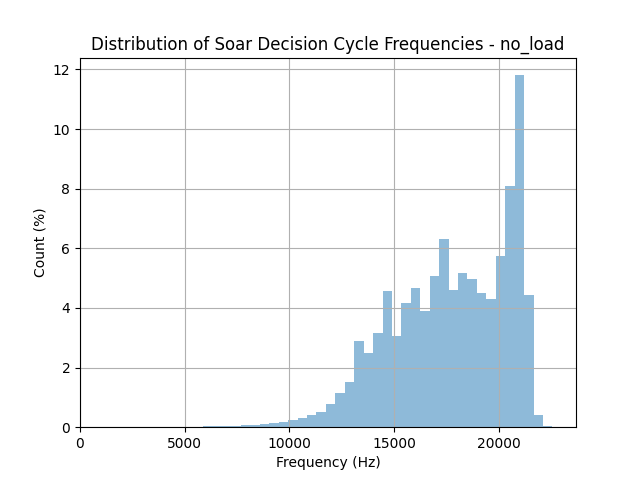

In [14]:
# compare_soar_kernel_frequencies(df_no_load[df_no_load["frequency"]==1200], "no_load")
compare_soar_kernel_frequencies(df_no_load, "no_load",False)

As visible in the distribution diagram, the input frequency does not have an impact on the Soar kernel execution speed.

## Scenario: SISO Analysis

In [15]:
# SISO df
siso_directory = "2026-02-13T09:58:44_CHANNELS_1-4000msg-f2000-f2500-f3000" # results from ./benchmark.sh 1
df_siso,df_siso_soar_trimmed = load_benchmark_data(siso_directory)

Trimmed 2000.0 Hz Soar timeseries to range: 1770976726.082 - 1770976732.082 (original: 1770976724.398 - 1770976733.749)
Trimmed 2500.0 Hz Soar timeseries to range: 1770976747.512 - 1770976753.112 (original: 1770976745.742 - 1770976755.880)
Trimmed 3000.0 Hz Soar timeseries to range: 1770976769.898 - 1770976825.454 (original: 1770976767.932 - 1770976825.926)
Trimmed 3000.0 Hz Soar timeseries to range: 1770976769.898 - 1770976825.454 (original: 1770976767.932 - 1770976825.926)


Sender: F 2500.0 Channel 0 M: 2516.36 Hz, SD: 207.356 Hz
Sender: F 3000.0 Channel 0 M: 3029.14 Hz, SD: 321.245 Hz
Sender: F 2000.0 Channel 0 M: 2006.4 Hz, SD: 119.945 Hz
siso 2000.0 Hz: Mean = 15917.24 Hz, SD = 4350.30 Hz
siso 2500.0 Hz: Mean = 15873.41 Hz, SD = 4187.34 Hz
siso 3000.0 Hz: Mean = 16183.37 Hz, SD = 5662.80 Hz


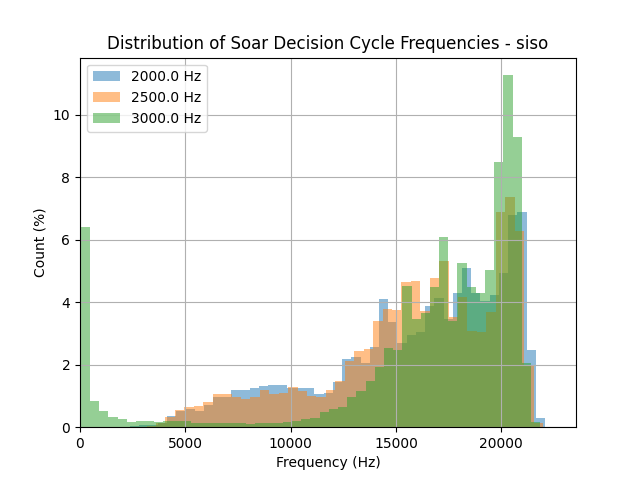

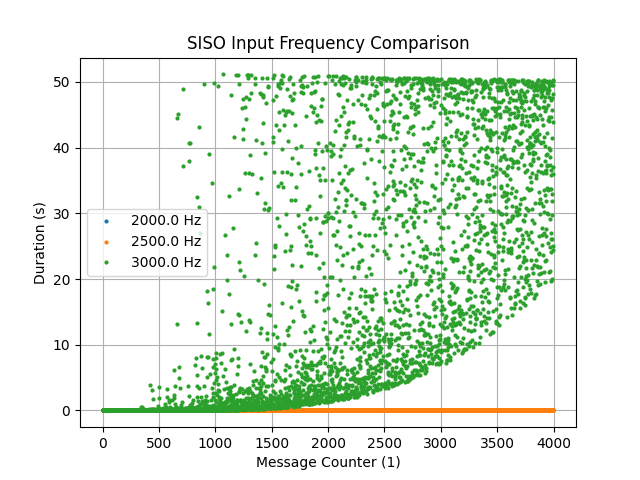

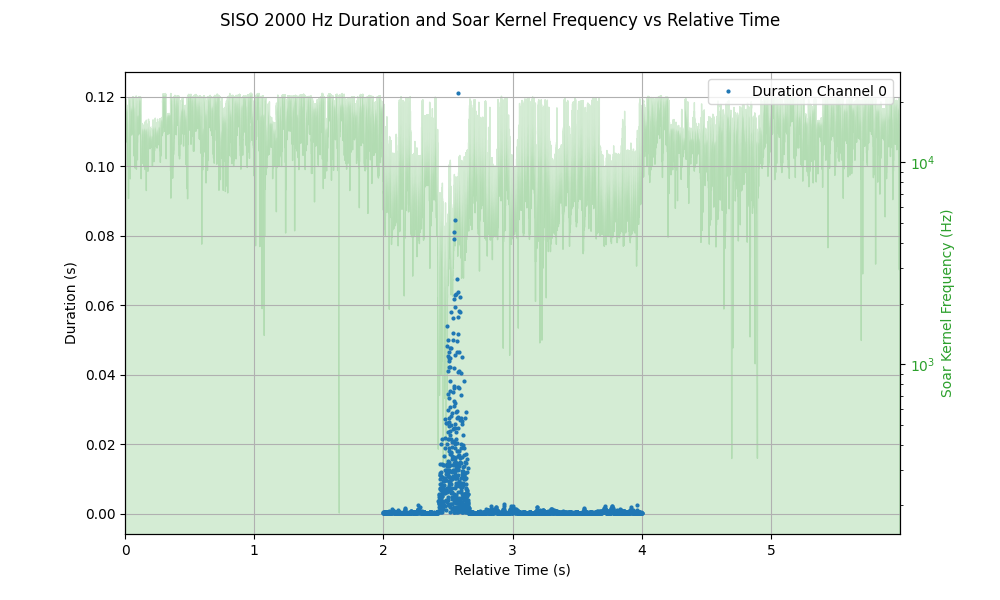

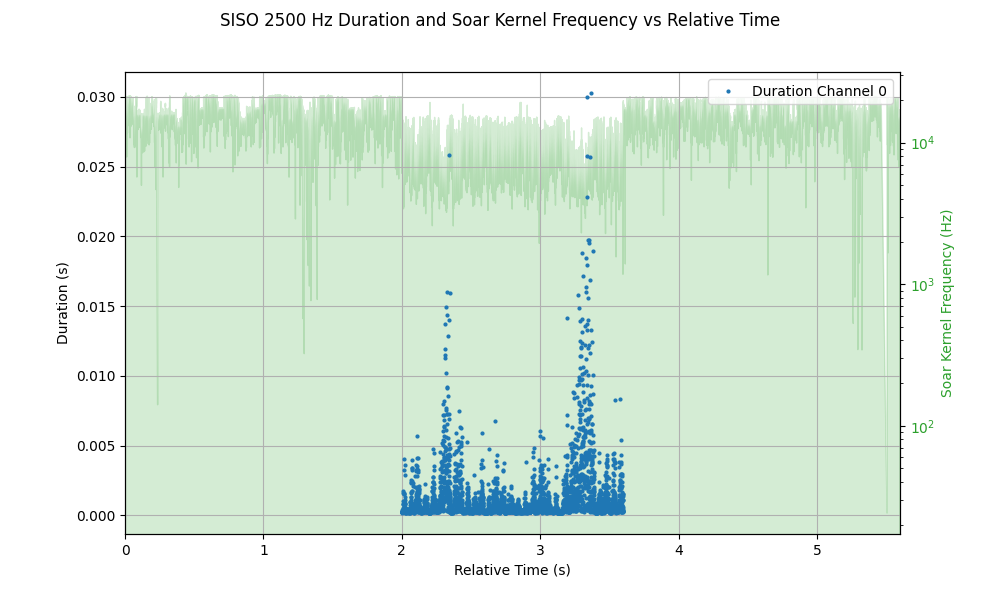

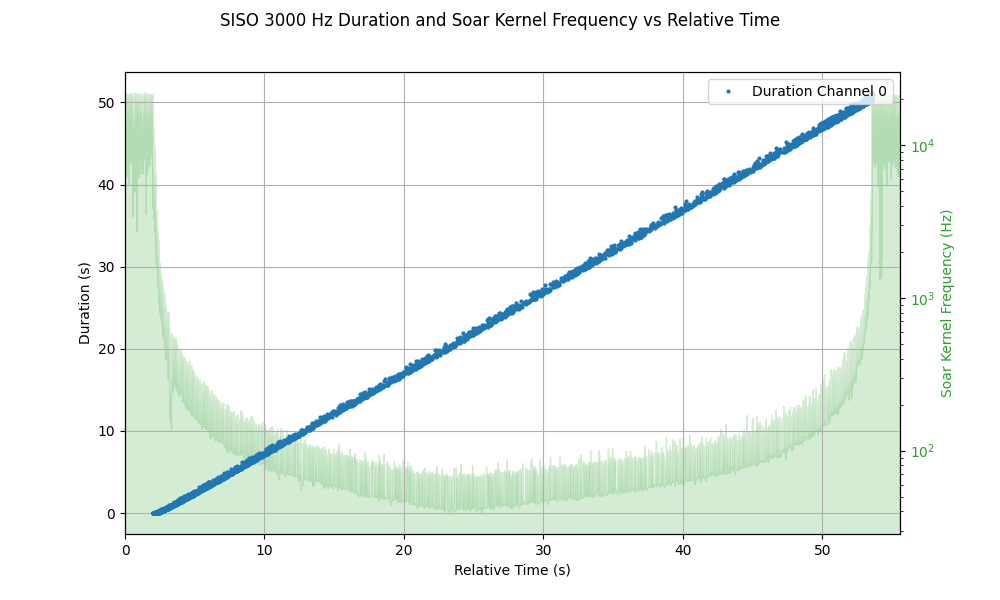

In [16]:
analyze_sender_frequency(df_siso)
compare_soar_kernel_frequencies(df_siso_soar_trimmed, "siso")
frequency_comparison_plot(df_siso,"SISO")
plot_dual_axis_comparison(df_siso, df_siso_soar_trimmed, "SISO")

# Comparison of Auto Delete vs No Auto Delete

In [17]:
normal = "2026-02-11T16:19:26_CHANNELS_1-8000messages"
df_normal, df_normal_soar_trimmed = load_benchmark_data(normal)

auto_delete_io = "2026-02-11T16:22:16_CHANNELS_1-8000messages-autodeleteio"
df_auto_delete_io, df_auto_delete_io_soar_trimmed = load_benchmark_data(auto_delete_io)

Trimmed 200.0 Hz Soar timeseries to range: 1770826768.498 - 1770826838.768 (original: 1770826766.499 - 1770826837.784)
Trimmed 200.0 Hz Soar timeseries to range: 1770826938.550 - 1770826982.545 (original: 1770826936.557 - 1770826994.789)


Sender: F 200.0 Channel 0 M: 200.017 Hz, SD: 1.85417 Hz


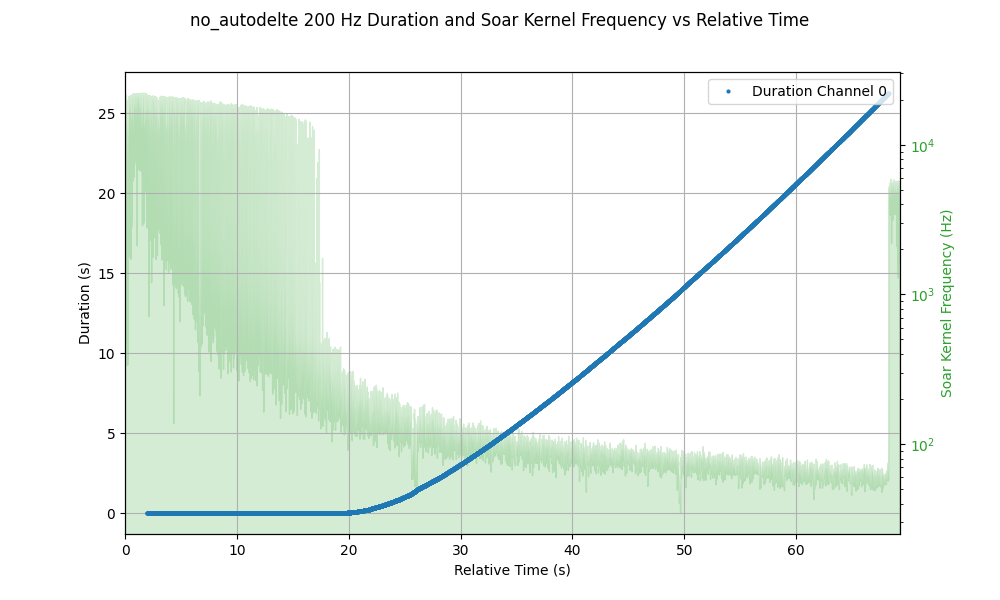

In [18]:
analyze_sender_frequency(df_normal)
plot_dual_axis_comparison(df_normal, df_normal_soar_trimmed, "no_autodelte")

Sender: F 200.0 Channel 0 M: 199.989 Hz, SD: 4.1615 Hz


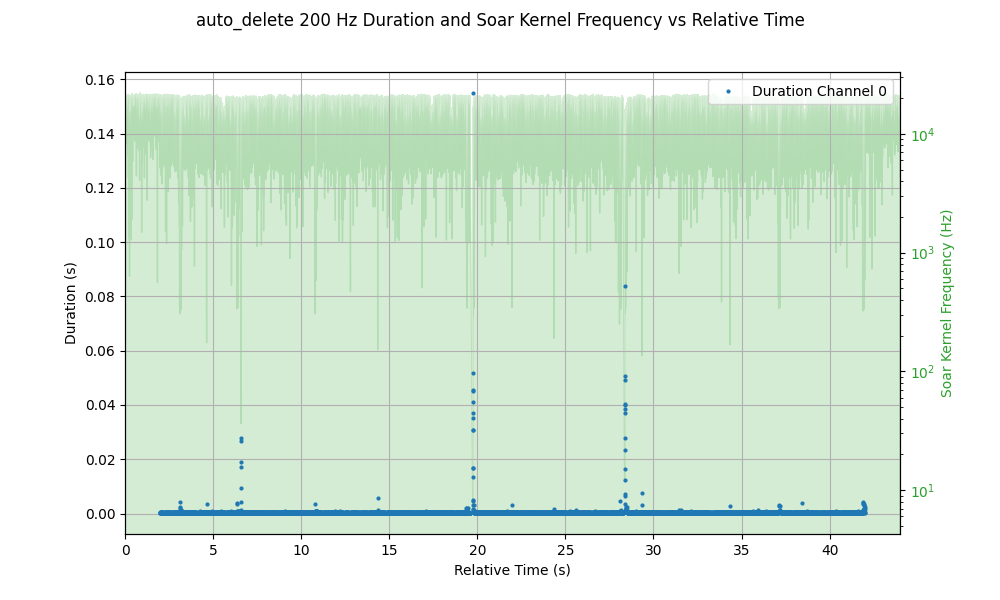

In [19]:
analyze_sender_frequency(df_auto_delete_io)
plot_dual_axis_comparison(df_auto_delete_io, df_auto_delete_io_soar_trimmed, "auto_delete")

## FIFO via Timestamp and preferences

Trimmed 2000.0 Hz Soar timeseries to range: 1770978615.102 - 1770978619.201 (original: 1770978613.100 - 1770978619.502)
Trimmed 2500.0 Hz Soar timeseries to range: 1770978632.267 - 1770978652.671 (original: 1770978630.584 - 1770978652.211)
Sender: F 2500.0 Channel 0 M: 2516.61 Hz, SD: 192.528 Hz
Sender: F 2000.0 Channel 0 M: 2009.19 Hz, SD: 122.089 Hz


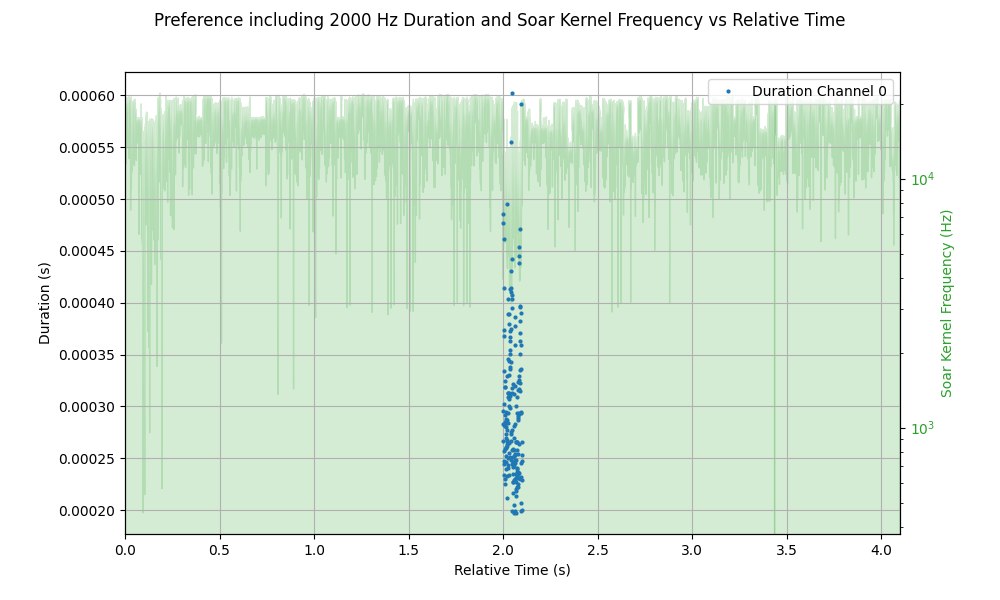

/tmp/ipykernel_131973/3177477005.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize=figsize)


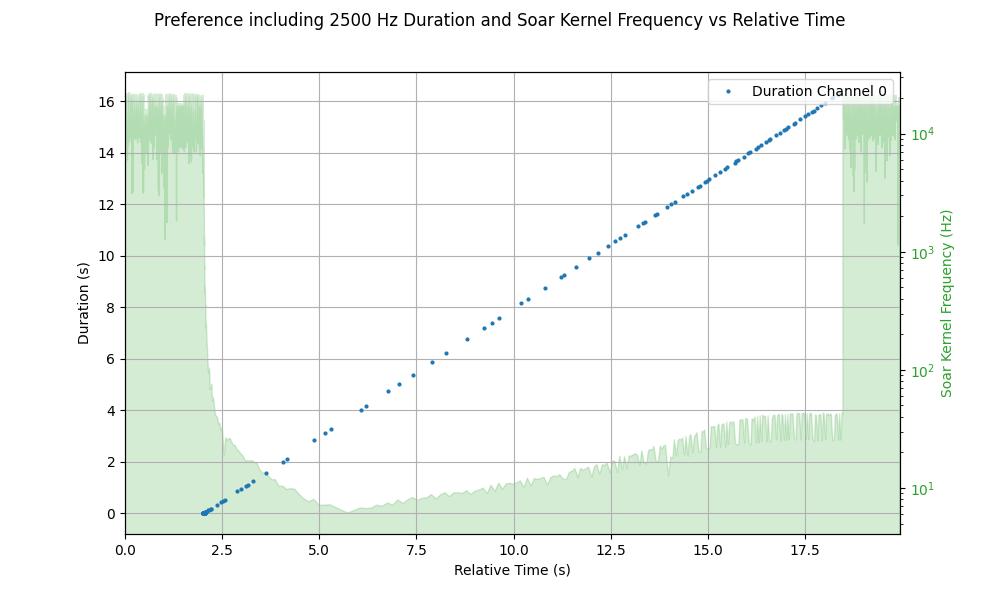

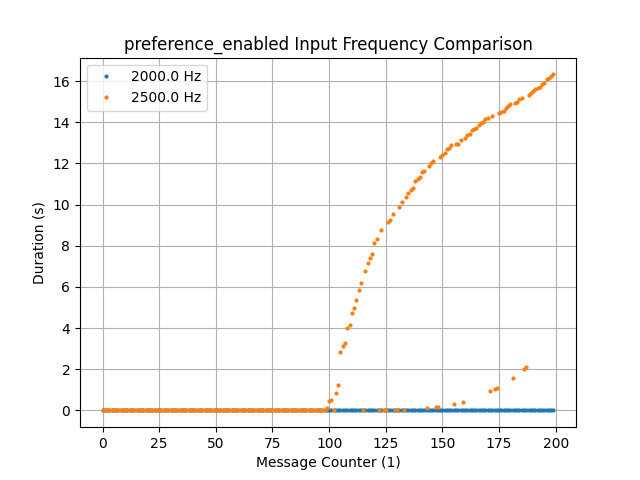

In [20]:
df_msg_preferences, df_soar_preferences = load_benchmark_data("2026-02-13T10:30:12_CHANNELS_1_preference-200msg-f2000-f2500")
analyze_sender_frequency(df_msg_preferences)
plot_dual_axis_comparison(df_msg_preferences,df_soar_preferences,"Preference including")
frequency_comparison_plot(df_msg_preferences, "preference_enabled")
